# NLP and Sentiment Analysis Project

## Introduction
In this project, we will be exploring Natural Language Processing (NLP) techniques and sentiment analysis. NLP is a field of study that focuses on the interaction between computers and human language. Sentiment analysis, on the other hand, is the process of determining the sentiment or emotion expressed in a piece of text.

## Objectives
The main objectives of this project are:
- Preprocessing text data by removing stopwords, punctuation, and performing tokenization.
- Building a sentiment analysis model using machine learning algorithms.
- Evaluating the performance of the sentiment analysis model using appropriate metrics.
- Applying the sentiment analysis model to analyze sentiment in a given dataset.

## Tools and Technologies
The following tools and technologies will be used in this project:
- Python programming language
- Jupyter Notebook
- Natural Language Toolkit (NLTK) library
- Scikit-learn library

## Workflow
1. Data Collection: Gather a dataset containing text data for sentiment analysis.
2. Data Preprocessing: Clean the text data by removing unnecessary elements such as stopwords and punctuation.
3. Text Tokenization: Split the text into individual words or tokens.
4. Feature Extraction: Convert the text data into numerical features that can be used by machine learning algorithms.
5. Model Training: Train a sentiment analysis model using machine learning algorithms such as Naive Bayes or Support Vector Machines.
6. Model Evaluation: Assess the performance of the trained model using metrics such as accuracy, precision, recall, and F1 score.
7. Sentiment Analysis: Apply the trained model to analyze sentiment in a given dataset.
8. Results and Conclusion: Summarize the findings of the sentiment analysis and draw conclusions.

## Conclusion
By completing this project, we will gain a better understanding of NLP techniques and sentiment analysis. We will also be able to apply these techniques to analyze sentiment in various text datasets, which can be useful in various domains such as social media monitoring, customer feedback analysis, and market research.


In [1]:
import re
import datetime
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from transformers import pipeline
from sentence_transformers import SentenceTransformer
from sentence_transformers.util import semantic_search
from IPython.display import display, Markdown


In [4]:
# Read the data from runway.csv, parse the date column, and assign it to runway
runway = pd.read_csv('runway.csv', parse_dates=['review_date'])

# Print the column info
print(runway.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1506 entries, 0 to 1505
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   user_id      1506 non-null   int64         
 1   item_id      1506 non-null   int64         
 2   rating       1506 non-null   int64         
 3   rented for   1506 non-null   object        
 4   review_text  1506 non-null   object        
 5   category     1506 non-null   object        
 6   height       1503 non-null   object        
 7   size         1506 non-null   int64         
 8   age          1500 non-null   float64       
 9   review_date  1506 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(4), object(4)
memory usage: 117.8+ KB
None


In [7]:
display(runway.head())

,user_id,item_id,rating,rented for,review_text,category,height,size,age,review_date
0,476109,139086,8,formal affair,it hit the floor perfectly with a pair of heel...,gown,"5' 3""",15,27.0,2017-12-19
1,203660,1126889,6,party,the dress is absolutely gorgeous unfortunately...,dress,"5' 4""",12,28.0,2022-01-03
2,868581,652189,8,wedding,even though it was lined with satin this was a...,dress,"5' 5""",24,30.0,2021-08-05
3,935076,1879504,8,wedding,this dress was greatit fit really well and was...,sheath,"5' 3""",14,37.0,2021-10-02
4,995023,1179146,10,party,super flattering i am usually a sizemi have a ...,dress,"5' 2""",14,37.0,2022-11-20


In [10]:
runway.shape

(1506, 10)

In [15]:
import os

OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
if OPENAI_API_KEY is None:
    raise ValueError("OPENAI_API_KEY environment variable not set")
else:
    print("OPENAI_API_KEY environment variable is set")


PINECONE_API_KEY = os.getenv("PINECONE_API_KEY")
if PINECONE_API_KEY is None:
    raise ValueError("PINECONE_API_KEY environment variable not set")
else:
    print("PINECONE_API_KEY environment variable is set")

PINECONE_ENVIRONMENT = os.getenv("PINECONE_ENVIRONMENT")
if PINECONE_ENVIRONMENT is None:    
    raise ValueError("PINECONE_ENVIRONMENT environment variable not set")
else:
    print("PINECONE_ENVIRONMENT environment variable is set")

OPENAI_API_KEY environment variable is set
PINECONE_API_KEY environment variable is set
PINECONE_ENVIRONMENT environment variable is set


<>:18: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:18: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-15-4f4b94695155>:18: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if PINECONE_ENVIRONMENT is 1:


In [16]:
# Remove the forward-slash character
runway['review_text_cleaned'] = runway['review_text'].str.replace(r"\/", "")

# Remove punctuation
runway['review_text_cleaned'] = runway['review_text_cleaned'].str.translate(string.punctuation)

# Remove digits
runway['review_text_cleaned'] = runway['review_text_cleaned'].str.replace(r"\d+", "")


# Remove running spaces
runway['review_text_cleaned'] = runway['review_text_cleaned'].str.replace(r"\{2,}", "")


# Make the text lowercase
runway['review_text_cleaned'] = runway['review_text_cleaned'].str.lower()

runway.head()

,user_id,item_id,rating,rented for,review_text,category,height,size,age,review_date,review_text_cleaned
0,476109,139086,8,formal affair,it hit the floor perfectly with a pair of heel...,gown,"5' 3""",15,27.0,2017-12-19,it hit the floor perfectly with a pair of heel...
1,203660,1126889,6,party,the dress is absolutely gorgeous unfortunately...,dress,"5' 4""",12,28.0,2022-01-03,the dress is absolutely gorgeous unfortunately...
2,868581,652189,8,wedding,even though it was lined with satin this was a...,dress,"5' 5""",24,30.0,2021-08-05,even though it was lined with satin this was a...
3,935076,1879504,8,wedding,this dress was greatit fit really well and was...,sheath,"5' 3""",14,37.0,2021-10-02,this dress was greatit fit really well and was...
4,995023,1179146,10,party,super flattering i am usually a sizemi have a ...,dress,"5' 2""",14,37.0,2022-11-20,super flattering i am usually a sizemi have a ...


In [17]:
sentimentAnalysis = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")
sent_analysis_output = sentimentAnalysis(runway['review_text_cleaned'].tolist())
print(sent_analysis_output)

[{'label': 'POSITIVE', 'score': 0.9998089671134949}, {'label': 'NEGATIVE', 'score': 0.9507226347923279}, {'label': 'NEGATIVE', 'score': 0.9872165322303772}, {'label': 'POSITIVE', 'score': 0.9960770010948181}, {'label': 'NEGATIVE', 'score': 0.9667245149612427}, {'label': 'POSITIVE', 'score': 0.9882996082305908}, {'label': 'POSITIVE', 'score': 0.7901321053504944}, {'label': 'POSITIVE', 'score': 0.9877718687057495}, {'label': 'POSITIVE', 'score': 0.9967693090438843}, {'label': 'POSITIVE', 'score': 0.9960691928863525}, {'label': 'NEGATIVE', 'score': 0.9993739724159241}, {'label': 'NEGATIVE', 'score': 0.7370165586471558}, {'label': 'NEGATIVE', 'score': 0.8242034912109375}, {'label': 'NEGATIVE', 'score': 0.6067991256713867}, {'label': 'POSITIVE', 'score': 0.9996150732040405}, {'label': 'POSITIVE', 'score': 0.995503842830658}, {'label': 'NEGATIVE', 'score': 0.9917631149291992}, {'label': 'POSITIVE', 'score': 0.9996963739395142}, {'label': 'POSITIVE', 'score': 0.997819185256958}, {'label': 'PO

In [23]:
### len of the sentiment analysis list is the same as the original number of rows
print(len(sent_analysis_output) == list(runway.shape)[0])

True


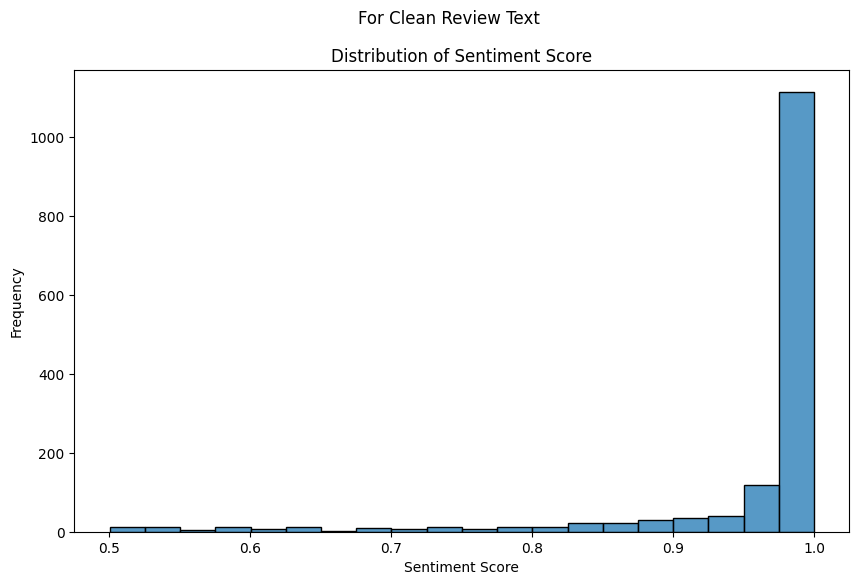

In [26]:
import seaborn as sns

# Parse sentiment analysis output into new columns
runway['clean_sentiment_category'] = [result['label'] for result in sent_analysis_output]
runway['clean_sentiment_score'] = [result['score'] for result in sent_analysis_output]

# Create histogram using seaborn
plt.figure(figsize=(10, 6))
sns.histplot(data=runway, x='clean_sentiment_score', bins=20)
plt.title('Distribution of Sentiment Score')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.suptitle('For Clean Review Text')
plt.show()


In [28]:
# Extract the year from the review_date column and assign it to the year column
runway['year'] = runway['review_date'].dt.year

# Count the number of reviews by year and clean_sentiment_category
chart_data = runway.groupby(['year', 'clean_sentiment_category']).size().reset_index(name='count')

chart_data

,year,clean_sentiment_category,count
0,2016,POSITIVE,3
1,2017,NEGATIVE,9
2,2017,POSITIVE,12
3,2018,NEGATIVE,24
4,2018,POSITIVE,54
5,2019,NEGATIVE,60
6,2019,POSITIVE,170
7,2020,NEGATIVE,62
8,2020,POSITIVE,180
9,2021,NEGATIVE,104


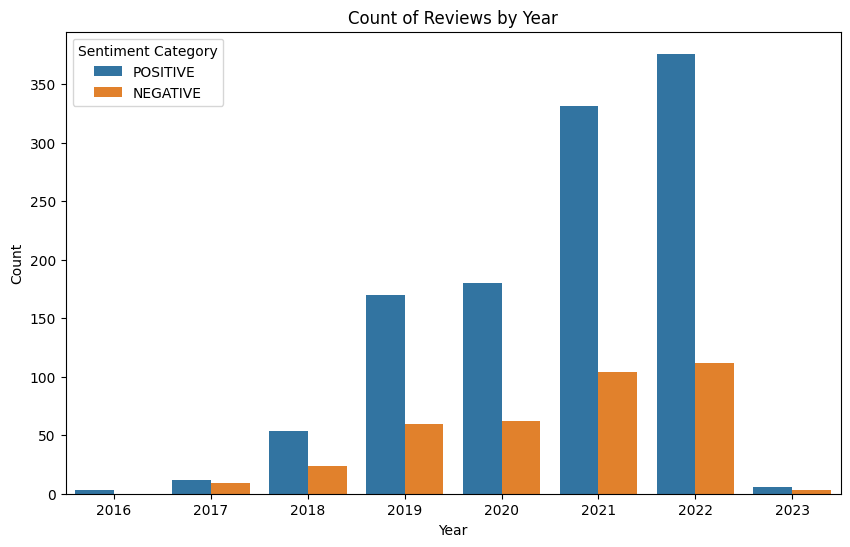

In [29]:
plt.figure(figsize=(10, 6))
sns.barplot(data=chart_data, x='year', y='count', hue='clean_sentiment_category')
plt.title('Count of Reviews by Year')
plt.xlabel('Year')
plt.ylabel('Count')
plt.legend(title='Sentiment Category')
plt.show()